In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import preprocessing, model_selection, ensemble, gaussian_process
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/experiments/../../modules/eumf_data.py:221: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/experiments/../../modules/eumf_data.py:263: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [3]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

In [4]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "gdp+unempl",
    "19+gdp+unempl",
    "ar",
    "ar+19",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
    ["value", "19", "24", "gdp", "unempl"],
]

lags = [
    [1],
    [2],
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False, False, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    kernel = gaussian_process.kernels.DotProduct() + gaussian_process.kernels.WhiteKernel()

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg = gaussian_process.GaussianProcessRegressor(kernel=kernel, random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_mae,
            cv=cv_default,
            # cv=cv_default,
            # dummy_encoder="drop",
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:47<00:00, 18.66s/it]


In [9]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



Empty DataFrame
Columns: []
Index: [19, gdp+unempl, 19+gdp+unempl, ar, ar+19, ar+gdp+unempl, ar+19+gdp+unempl]

In [11]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                       score_time                   test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                     mean      std        sem        mean     std      sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
bench-rw             0.004   6.736e-04  2.381e-04    0.006    0.001  3.738e-04  -0.070   0.013  0.005   -0.070   0.003  0.001   -0.105   0.027  0.010   -0.108    0.007  0.002           0.414          0.224  0.079           0.661           0.045  0.016     0.505    0.273  0.096     0.705     0.061  0.022      0.057      0.065  0.023       0.059      0.016  0.006
bench-rw-realistic   0.004   1.408e-03  4.978e-04    0.006    0.002  6.970e-04  -0.092   0.020  0.007   -0.093   0.005  0.002   -0.139   0.047  0.017   -0.146    0.012  0.004           0.107          0.201  0.071           0.388           0.077  0.027     0.231    0.305  0.108     0.466     0.097  0.034      0.034      0.056  0.020       0.037      0.014  0.005
19                   1.444   5.071e-01  1.793e-01    0.039    0.024  8.439e-03  -0.100   0.032  0.011   -0.087   0.009  0.003   -0.151   0.059  0.021   -0.138    0.014  0.005          -0.007          0.345  0.122           0.458           0.032  0.011     0.123    0.416  0.147     0.531     0.035  0.013      0.027      0.044  0.016       0.042      0.009  0.003
gdp+unempl           1.272   4.161e-01  1.471e-01    0.028    0.009  3.279e-03  -0.122   0.039  0.014   -0.098   0.010  0.003   -0.167   0.058  0.020   -0.140    0.014  0.005          -0.205          0.375  0.133           0.436           0.040  0.014    -0.132    0.593  0.210     0.513     0.045  0.016      0.005      0.034  0.012       0.031      0.009  0.003
19+gdp+unempl        1.216   4.552e-01  1.609e-01    0.032    0.004  1.329e-03  -0.100   0.030  0.011   -0.084   0.008  0.003   -0.146   0.057  0.020   -0.127    0.013  0.005           0.013          0.324  0.115           0.536           0.039  0.014     0.177    0.385  0.136     0.599     0.040  0.014      0.026      0.043  0.015       0.045      0.010  0.004
ar                   1.210   4.817e-01  1.703e-01    0.024    0.007  2.552e-03  -0.091   0.035  0.012   -0.080   0.006  0.002   -0.134   0.056  0.020   -0.124    0.012  0.004           0.257          0.205  0.073           0.555           0.035  0.013     0.329    0.286  0.101     0.615     0.044  0.016      0.036      0.043  0.015       0.049      0.012  0.004
ar+19                1.523   5.876e-01  2.078e-01    0.037    0.028  9.898e-03  -0.083   0.027  0.010   -0.073   0.006  0.002   -0.125   0.053  0.019   -0.115    0.012  0.004           0.281          0.252  0.089           0.623           0.030  0.011     0.416    0.228  0.081     0.674     0.031  0.011      0.043      0.047  0.017       0.056      0.013  0.004
ar+gdp+unempl        2.690   1.986e+00  7.022e-01    0.083    0.065  2.290e-02  -0.094   0.029  0.010   -0.078   0.005  0.002   -0.132   0.047  0.017   -0.114    0.011  0.004           0.179          0.307  0.109           0.627           0.038  0.014     0.266    0.369  0.131     0.677     0.046  0.016      0.033      0.047  0.016       0.051      0.013  0.005
ar+19+gdp+unempl     1.958   1.347e+00  4.761e-01    0.064    0.081  2.862e-02  -0.087   0.026  0.009   -0.072   0.006  0.002   -0.126   0.048  0.017   -0.108    0.011  0.004           0.224          0.294  0.104           0.663           0.031  0.011     0.372    0.279  0.099     0.709     0.033  0.012      0.039      0.047  0.017       0.057      0.013  0.004

In [12]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

mae   rmse   explained_variance  r2_mod  delta_mae
bench-rw           -0.061 -0.086         0.107         0.215  9.187e-03
ar+19+gdp+unempl   -0.067 -0.088         0.067         0.190  3.592e-03
ar+19              -0.066 -0.089         0.200         0.171  4.337e-03
ar                 -0.065 -0.089         0.181         0.159  5.643e-03
ar+gdp+unempl      -0.071 -0.090        -0.002         0.146 -4.334e-04
bench-rw-realistic -0.068 -0.094        -0.031         0.069  2.072e-03
19+gdp+unempl      -0.076 -0.106        -0.378        -0.194 -6.152e-03
gdp+unempl         -0.092 -0.117        -0.691        -0.440 -2.172e-02
19                 -0.086 -0.118        -0.258        -0.465 -1.559e-02

Ljung Box test to check if CV works

In [13]:
i_best = model_names.index("ar+19+gdp+unempl")
y_train_pred = estimators[i_best].predict(train_stacked.x)
ser_delta = y_train_pred - train_stacked.y
df_delta = ser_delta.unstack()

for c in df_delta.columns:
    print(c)
    print(sm.stats.acorr_ljungbox(df_delta[c], lags=4, return_df=False))

AT+CH
   lb_stat  lb_pvalue
1   2.430     0.119  
2   6.470     0.039  
3  12.765     0.005  
4  15.776     0.003  
BE+NL+LU
   lb_stat  lb_pvalue
1   1.864     0.172  
2   5.479     0.065  
3   5.851     0.119  
4   6.543     0.162  
BG
   lb_stat  lb_pvalue
1   7.500     0.006  
2   9.221     0.010  
3  13.206     0.004  
4  13.986     0.007  
CZ+SK
   lb_stat  lb_pvalue
1   1.621     0.203  
2   2.642     0.267  
3   2.650     0.449  
4   4.460     0.347  
ES
   lb_stat  lb_pvalue
1   4.608     0.032  
2   7.742     0.021  
3   7.995     0.046  
4  13.166     0.010  
FR
   lb_stat  lb_pvalue
1   0.131     0.718  
2   4.301     0.116  
3   4.517     0.211  
4   5.352     0.253  
GB
   lb_stat  lb_pvalue
1   9.345     0.002  
2  11.216     0.004  
3  11.736     0.008  
4  12.211     0.016  
GR
   lb_stat  lb_pvalue
1  16.218   5.645e-05
2  20.526   3.491e-05
3  20.545   1.308e-04
4  22.110   1.906e-04
HR
   lb_stat  lb_pvalue
1  12.684   3.688e-04
2  12.879   1.597e-03
3  14.462   2.3

#### Performance by year (CV+test)

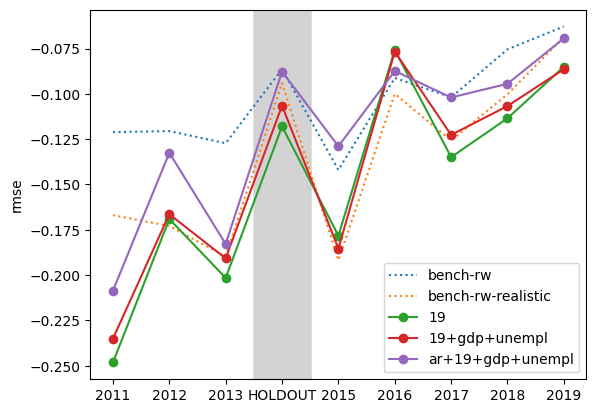

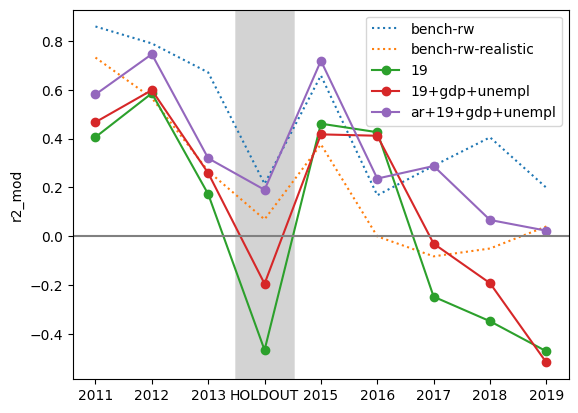

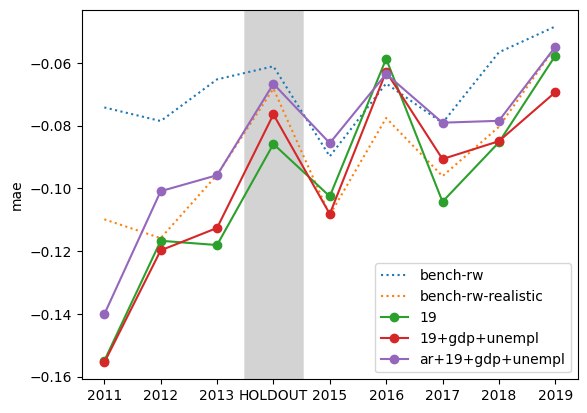

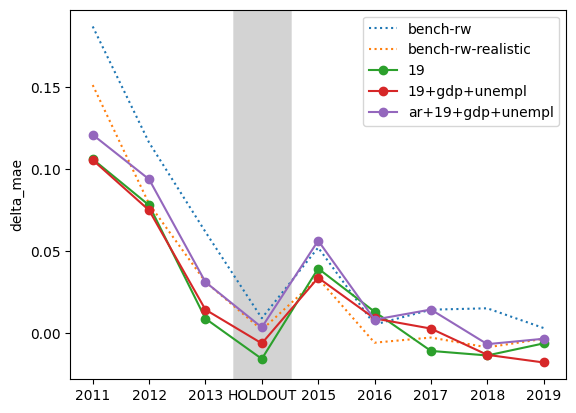

In [14]:
comp_models = ["bench-rw", "bench-rw-realistic", "19", "19+gdp+unempl", "ar+19+gdp+unempl"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["rmse", "r2_mod", "mae", "delta_mae"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
    )
    if m=="r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()

### Point analyses Trends vs no Trends

In [11]:
i_1 = model_names.index("ar+gdp+unempl")
i_2 = model_names.index("ar+19+gdp+unempl")

arr_pred_1 = model_selection.cross_val_predict(
    estimators[i_1], train_stackeds[i_1].x, train_stackeds[i_1].y, cv=cv_default
)
arr_pred_2 = model_selection.cross_val_predict(
    estimators[i_2], train_stackeds[i_2].x, train_stackeds[i_2].y, cv=cv_default
)

df_pred = train_stackeds[i_1].y.to_frame(name="true").reset_index()
df_pred["year"] = df_pred["date"].dt.year.astype(str)
df_pred["pred_value"] = arr_pred_1
df_pred["pred_trends"] = arr_pred_2
df_pred["err_value"] = np.abs(df_pred["true"] - df_pred["pred_value"])
df_pred["err_trends"] = np.abs(df_pred["true"] - df_pred["pred_trends"])
df_pred["delta"] = df_pred["err_value"] - df_pred["err_trends"]

df_pred.head()


date     country   true   year  pred_value  pred_trends  err_value  err_trends  delta
0 2011-03-31     AT+CH  0.053  2011     0.048       0.082       0.005       0.029   -0.024
1 2011-03-31  BE+NL+LU  0.099  2011     0.053       0.043       0.047       0.057   -0.010
2 2011-03-31        BG  0.343  2011     0.239       0.275       0.104       0.067    0.036
3 2011-03-31     CZ+SK  0.126  2011     0.084       0.138       0.042       0.012    0.031
4 2011-03-31        ES  0.355  2011     0.299       0.433       0.057       0.078   -0.021

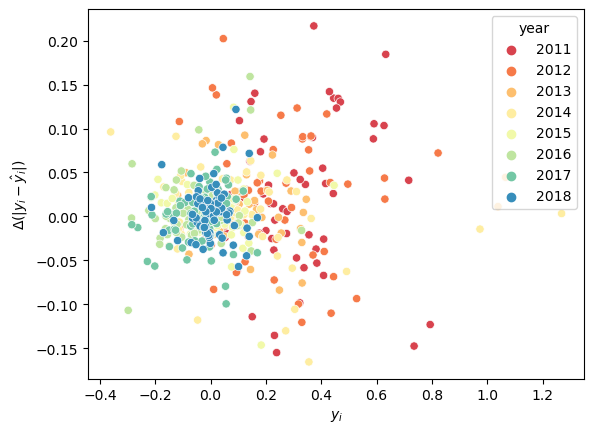

In [12]:
sns.scatterplot(data=df_pred, x="true", y="delta", hue="year", palette="Spectral")
plt.xlabel(r"$y_i$")
plt.ylabel(r"$\Delta(|y_i-\^y_i|)$")
plt.show()

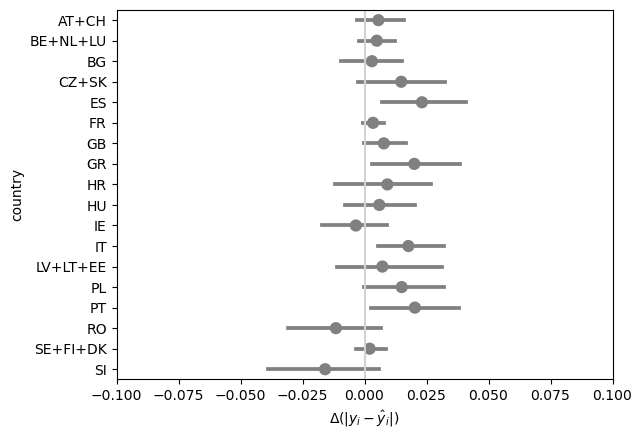

In [13]:
sns.pointplot(
    data=df_pred,
    y="country",
    x="delta",
    linestyles="",
    color="grey",
)
plt.axvline(0.0, c="lightgrey")
plt.xlabel(r"$\Delta(|y_i-\^y_i|)$")
plt.xlim(-0.1,0.1)
plt.show()

### Performance by country

##### prepare dummy scores (realistic)

In [14]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[1], train_unstackeds[1], cv_default)

##### best model without AR lags: KW19 + econ

test scores

In [15]:
i = model_names.index("19+gdp+unempl")


In [16]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


mae   rmse   explained_variance  r2_mod  delta_mae
IT        0.044  0.047         0.273         0.362  1.351e-02
HR        0.157  0.172        -0.032         0.321  4.002e-02
GR        0.076  0.088        -0.343         0.246  9.826e-03
PL        0.098  0.114        -0.096         0.234  1.531e-02
SE+FI+DK  0.049  0.058         0.129         0.153 -1.430e-03
LV+LT+EE  0.047  0.057         0.122         0.032 -1.529e-03
GB        0.083  0.127         0.020         0.020  5.386e-03
SI        0.091  0.124         0.011        -0.007  2.085e-02
PT        0.062  0.064        -0.571        -0.027 -1.095e-02
FR        0.013  0.016         0.018        -0.069  2.451e-03
AT+CH     0.044  0.049         0.187        -0.102 -3.843e-03
HU        0.201  0.203        -0.169        -0.158 -1.415e-02
BG        0.038  0.048        -0.411        -0.233 -4.676e-03
ES        0.032  0.043         0.143        -0.276  8.637e-04
RO        0.094  0.108         0.108        -0.307 -1.454e-02
IE        0.055  0.060         0.100        -0.666 -1.561e-02
BE+NL+LU  0.039  0.044        -0.605        -1.191 -1.339e-02
CZ+SK     0.031  0.047        -3.250        -6.118 -1.756e-02

CV scores

In [35]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("mae", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                r2_mod                delta_mae              
          mean   std    sem    mean   std    sem          mean          std    sem    mean    std    sem      mean    std    sem  
HR        0.213  0.175  0.062  0.259  0.228  0.081       -0.865         2.480  0.877 -0.333   1.586  0.561    0.035   0.120  0.042
SI        0.195  0.125  0.044  0.224  0.132  0.047       -0.463         0.602  0.213 -0.003   0.878  0.310    0.050   0.113  0.040
GR        0.150  0.085  0.030  0.168  0.086  0.030       -0.923         2.102  0.743 -5.828  13.843  4.894    0.023   0.187  0.066
PT        0.116  0.078  0.028  0.130  0.084  0.030       -0.305         0.652  0.231  0.349   0.632  0.223    0.054   0.103  0.036
LV+LT+EE  0.099  0.053  0.019  0.107  0.059  0.021       -0.388         1.412  0.499 -0.990   3.146  1.112    0.017   0.062  0.022
RO        0.097  0.069  0.024  0.108  0.070  0.025       -0.335         0.754  0.267  0.062   1.095  0.387    0.059   0.074  0.026
HU        0.094  0.080  0.028  0.108  0.094  0.033       -0.807         1.826  0.646  0.396   0.369  0.130    0.042   0.045  0.016
ES        0.093  0.024  0.008  0.101  0.023  0.008        0.370         0.346  0.123 -0.278   2.147  0.759    0.101   0.144  0.051
BG        0.085  0.057  0.020  0.091  0.058  0.021       -0.630         1.640  0.580 -7.724  22.584  7.985    0.026   0.084  0.030
CZ+SK     0.081  0.061  0.022  0.102  0.069  0.024       -0.060         0.407  0.144  0.292   0.362  0.128    0.032   0.037  0.013
IE        0.080  0.025  0.009  0.090  0.027  0.010       -0.130         0.522  0.185 -0.047   0.753  0.266    0.021   0.070  0.025
IT        0.072  0.052  0.018  0.081  0.052  0.018       -0.195         0.797  0.282  0.396   0.525  0.186    0.091   0.108  0.038
PL        0.067  0.050  0.018  0.079  0.057  0.020        0.234         0.370  0.131  0.398   0.416  0.147    0.039   0.082  0.029
AT+CH     0.065  0.059  0.021  0.078  0.070  0.025       -0.268         0.720  0.255 -0.737   1.419  0.502   -0.010   0.033  0.012
BE+NL+LU  0.056  0.022  0.008  0.065  0.025  0.009       -0.357         0.551  0.195 -0.776   1.102  0.390   -0.006   0.028  0.010
GB        0.046  0.022  0.008  0.057  0.023  0.008       -0.870         1.560  0.552 -1.137   4.235  1.497    0.008   0.025  0.009
SE+FI+DK  0.035  0.011  0.004  0.042  0.012  0.004       -0.077         0.607  0.215 -0.262   0.952  0.337    0.008   0.030  0.011
FR        0.032  0.012  0.004  0.040  0.015  0.005       -6.058        16.548  5.851  0.218   0.494  0.175    0.012   0.014  0.005

plot RMSE absolute

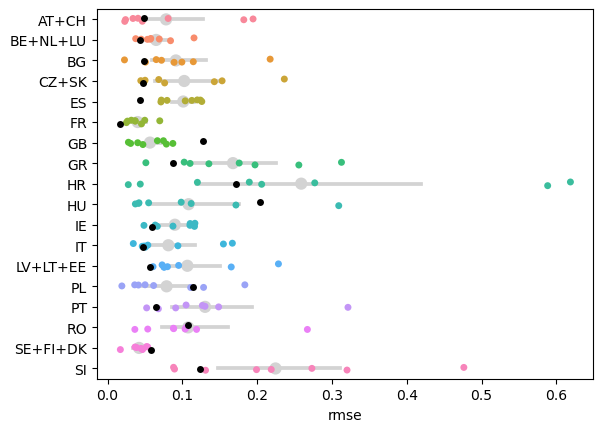

In [36]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse",)
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

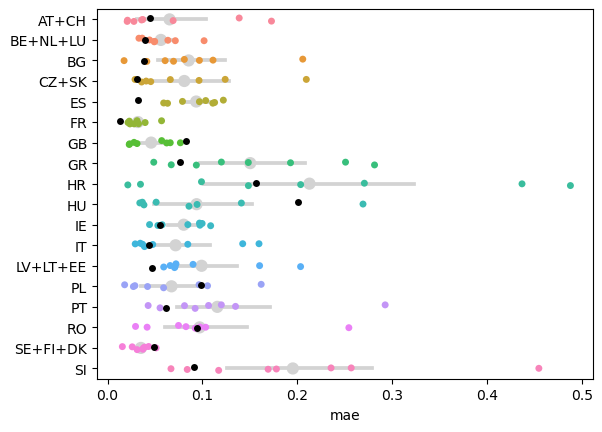

In [37]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

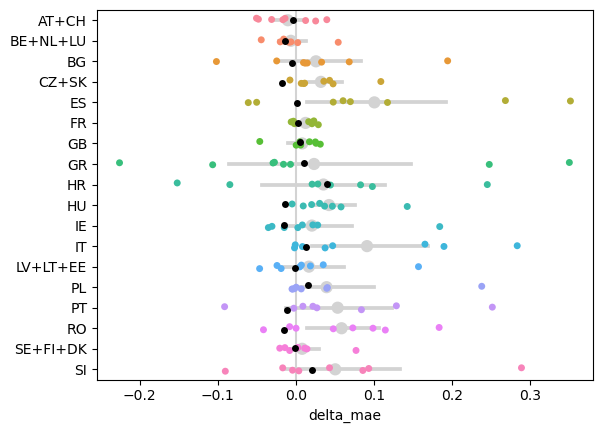

In [38]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.show()


##### best model with AR lags: value + KW19 + econ

test scores

In [39]:
i = model_names.index("ar+19+gdp+unempl")


In [40]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


mae   rmse   explained_variance  r2_mod  delta_mae
HU        0.115  0.119        -0.117         0.604  7.182e-02
GR        0.049  0.065         0.331         0.585  3.672e-02
IE        0.022  0.032        -0.020         0.516  1.748e-02
IT        0.040  0.041         0.433         0.511  1.800e-02
HR        0.137  0.153         0.060         0.464  5.977e-02
AT+CH     0.040  0.041         0.824         0.240  9.052e-04
PL        0.106  0.114        -0.812         0.233  8.115e-03
BG        0.037  0.039         0.178         0.205 -2.989e-03
PT        0.051  0.060        -0.396         0.097  9.804e-05
SE+FI+DK  0.055  0.068        -0.170        -0.156 -8.015e-03
ES        0.038  0.041        -0.348        -0.165 -4.966e-03
FR        0.015  0.017        -0.251        -0.297  1.455e-04
RO        0.091  0.111        -0.181        -0.383 -1.088e-02
LV+LT+EE  0.062  0.069        -1.786        -0.403 -1.662e-02
GB        0.143  0.158        -0.840        -0.506 -5.471e-02
BE+NL+LU  0.037  0.039        -0.271        -0.755 -1.134e-02
SI        0.144  0.177        -1.186        -1.063 -3.240e-02
CZ+SK     0.041  0.046        -0.217        -5.556 -2.755e-02

CV scores

In [41]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("rmse", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                 r2_mod                delta_mae              
          mean   std    sem    mean   std    sem          mean          std     sem    mean    std    sem      mean    std    sem  
HR        0.179  0.168  0.059  0.215  0.214  0.076       -1.906         3.395   1.200  0.206   0.895  0.316    0.069   0.101  0.036
SI        0.179  0.128  0.045  0.206  0.143  0.051       -0.661         0.550   0.195  0.039   0.976  0.345    0.066   0.112  0.040
GR        0.130  0.067  0.024  0.150  0.077  0.027       -1.192         2.168   0.766 -4.068  10.336  3.654    0.043   0.194  0.068
PT        0.102  0.065  0.023  0.120  0.071  0.025       -0.304         0.659   0.233  0.416   0.494  0.175    0.067   0.106  0.037
CZ+SK     0.086  0.059  0.021  0.105  0.068  0.024        0.172         0.300   0.106  0.179   0.505  0.178    0.027   0.040  0.014
LV+LT+EE  0.080  0.060  0.021  0.097  0.071  0.025       -0.892         1.746   0.617 -0.846   2.746  0.971    0.036   0.100  0.035
IE        0.082  0.020  0.007  0.093  0.024  0.008       -2.149         5.036   1.780 -0.104   0.831  0.294    0.019   0.063  0.022
ES        0.077  0.030  0.011  0.090  0.034  0.012        0.103         0.393   0.139 -0.243   2.102  0.743    0.117   0.159  0.056
RO        0.078  0.060  0.021  0.087  0.062  0.022       -1.160         2.183   0.772  0.013   1.541  0.545    0.078   0.093  0.033
BG        0.077  0.043  0.015  0.086  0.047  0.017       -2.057         3.345   1.183 -2.539   7.665  2.710    0.035   0.090  0.032
HU        0.073  0.047  0.017  0.081  0.052  0.018       -0.619         1.347   0.476  0.541   0.390  0.138    0.064   0.065  0.023
PL        0.065  0.052  0.019  0.077  0.061  0.021        0.359         0.299   0.106  0.397   0.414  0.146    0.041   0.101  0.036
AT+CH     0.060  0.056  0.020  0.073  0.067  0.024       -0.145         0.785   0.278 -0.278   0.863  0.305   -0.005   0.029  0.010
IT        0.050  0.033  0.012  0.058  0.038  0.013       -0.504         1.796   0.635  0.500   0.587  0.208    0.113   0.127  0.045
BE+NL+LU  0.048  0.014  0.005  0.056  0.013  0.004       -1.142         2.275   0.804 -0.198   0.527  0.186    0.002   0.016  0.006
GB        0.046  0.023  0.008  0.056  0.025  0.009       -1.813         2.063   0.729 -0.622   2.589  0.915    0.008   0.017  0.006
SE+FI+DK  0.037  0.013  0.005  0.046  0.014  0.005       -0.976         2.064   0.730 -0.363   0.933  0.330    0.006   0.027  0.010
FR        0.034  0.014  0.005  0.042  0.018  0.006      -17.970        49.317  17.436  0.148   0.530  0.187    0.010   0.014  0.005

plot RMSE absolute

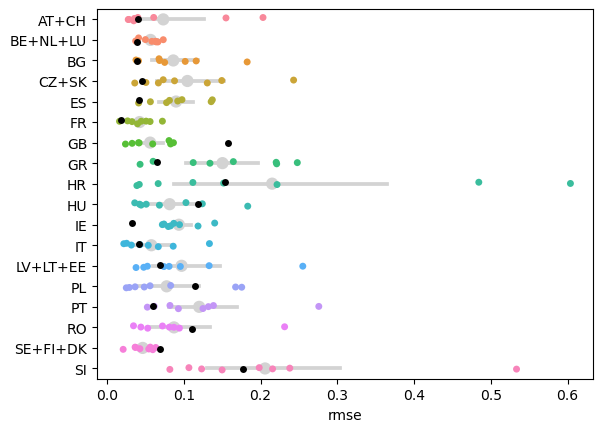

In [42]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

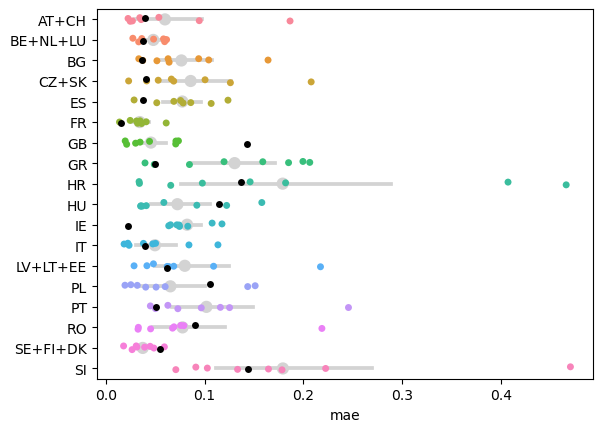

In [43]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

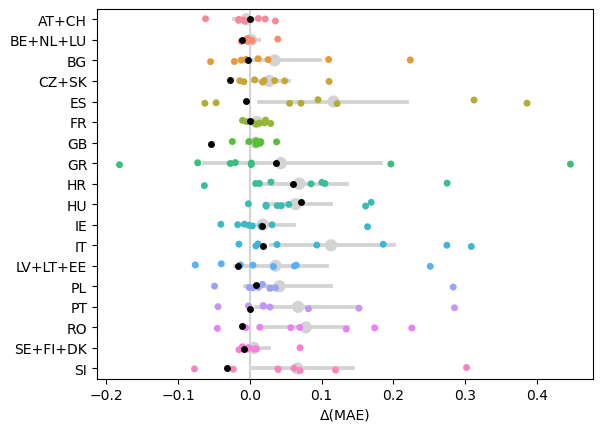

In [44]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [45]:
i1 = model_names.index("19+gdp+unempl")
i2 = model_names.index("gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

# cv_diff_agg["rmse"]

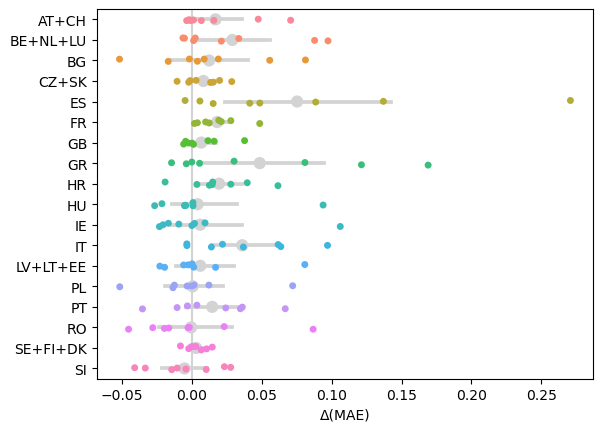

In [46]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
# sns.boxenplot(
#     data=cv_diff.reset_index(),
#     y="level_0",
#     x="mae",
#     # linestyles="",
#     # color="lightgrey",
#     # linewidth=0.0
# )
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


##### with own lags

In [47]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0,)

cv_diff_agg["rmse"]

mean      std    sem 
AT+CH     3.203e-03  0.013  0.005
BE+NL+LU  2.948e-03  0.012  0.004
BG        5.124e-03  0.020  0.007
CZ+SK     2.033e-02  0.038  0.014
ES        2.400e-02  0.021  0.007
FR        6.480e-03  0.005  0.002
GB        6.302e-03  0.010  0.004
GR        1.786e-02  0.033  0.012
HR        7.448e-03  0.034  0.012
HU        4.649e-03  0.012  0.004
IE       -7.693e-04  0.016  0.006
IT        1.855e-02  0.028  0.010
LV+LT+EE  1.022e-02  0.038  0.013
PL        1.940e-02  0.030  0.011
PT        1.685e-02  0.038  0.014
RO       -9.357e-03  0.036  0.013
SE+FI+DK  1.625e-03  0.011  0.004
SI       -2.389e-02  0.030  0.010

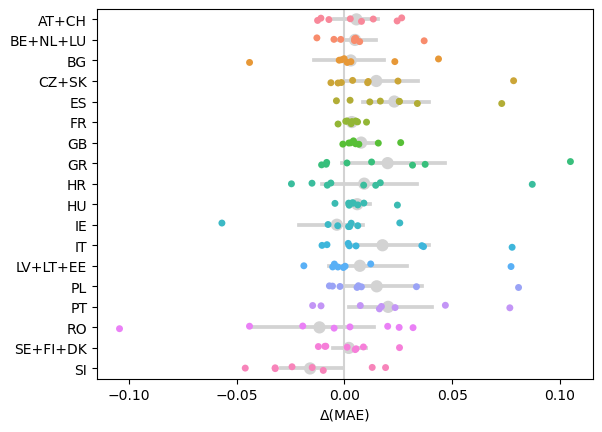

In [48]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### feature importance

In [49]:
i = model_names.index("19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_1                1.329e-01
19_2                1.098e-01
19_3                7.450e-02
unempl_4            7.060e-02
unempl_3            6.959e-02
unempl_2            6.630e-02
unempl_5            6.519e-02
unempl_6            6.054e-02
19_6                5.399e-02
19_5                4.713e-02
19_4                4.228e-02
gdp_2               4.021e-02
gdp_6               3.299e-02
gdp_3               2.934e-02
gdp_4               2.589e-02
gdp_5               2.407e-02
country_HR          1.483e-02
country_SI          6.788e-03
country_RO          5.758e-03
country_GR          5.701e-03
country_ES          3.235e-03
country_HU          2.867e-03
country_PT          2.557e-03
country_IT          2.206e-03
country_IE          1.868e-03
country_BG          1.590e-03
country_BE+NL+LU    1.374e-03
country_AT+CH       1.246e-03
country_CZ+SK       1.213e-03
country_LV+LT+EE    1.155e-03
country_PL          9.780e-04
country_GB          4.896e-04
country_SE+FI+DK    4.097e-04
country_FR

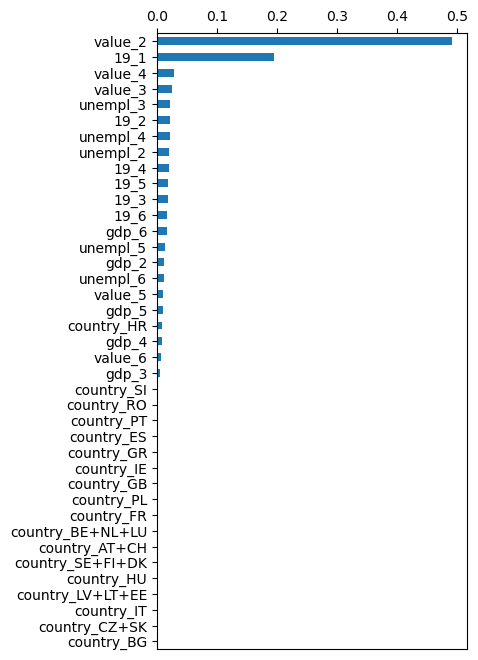

In [50]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
plt.figure(figsize=(4,8))
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=True
).plot(kind="barh")
plt.gca().xaxis.tick_top()
plt.show()

#### Plot prediction

all features

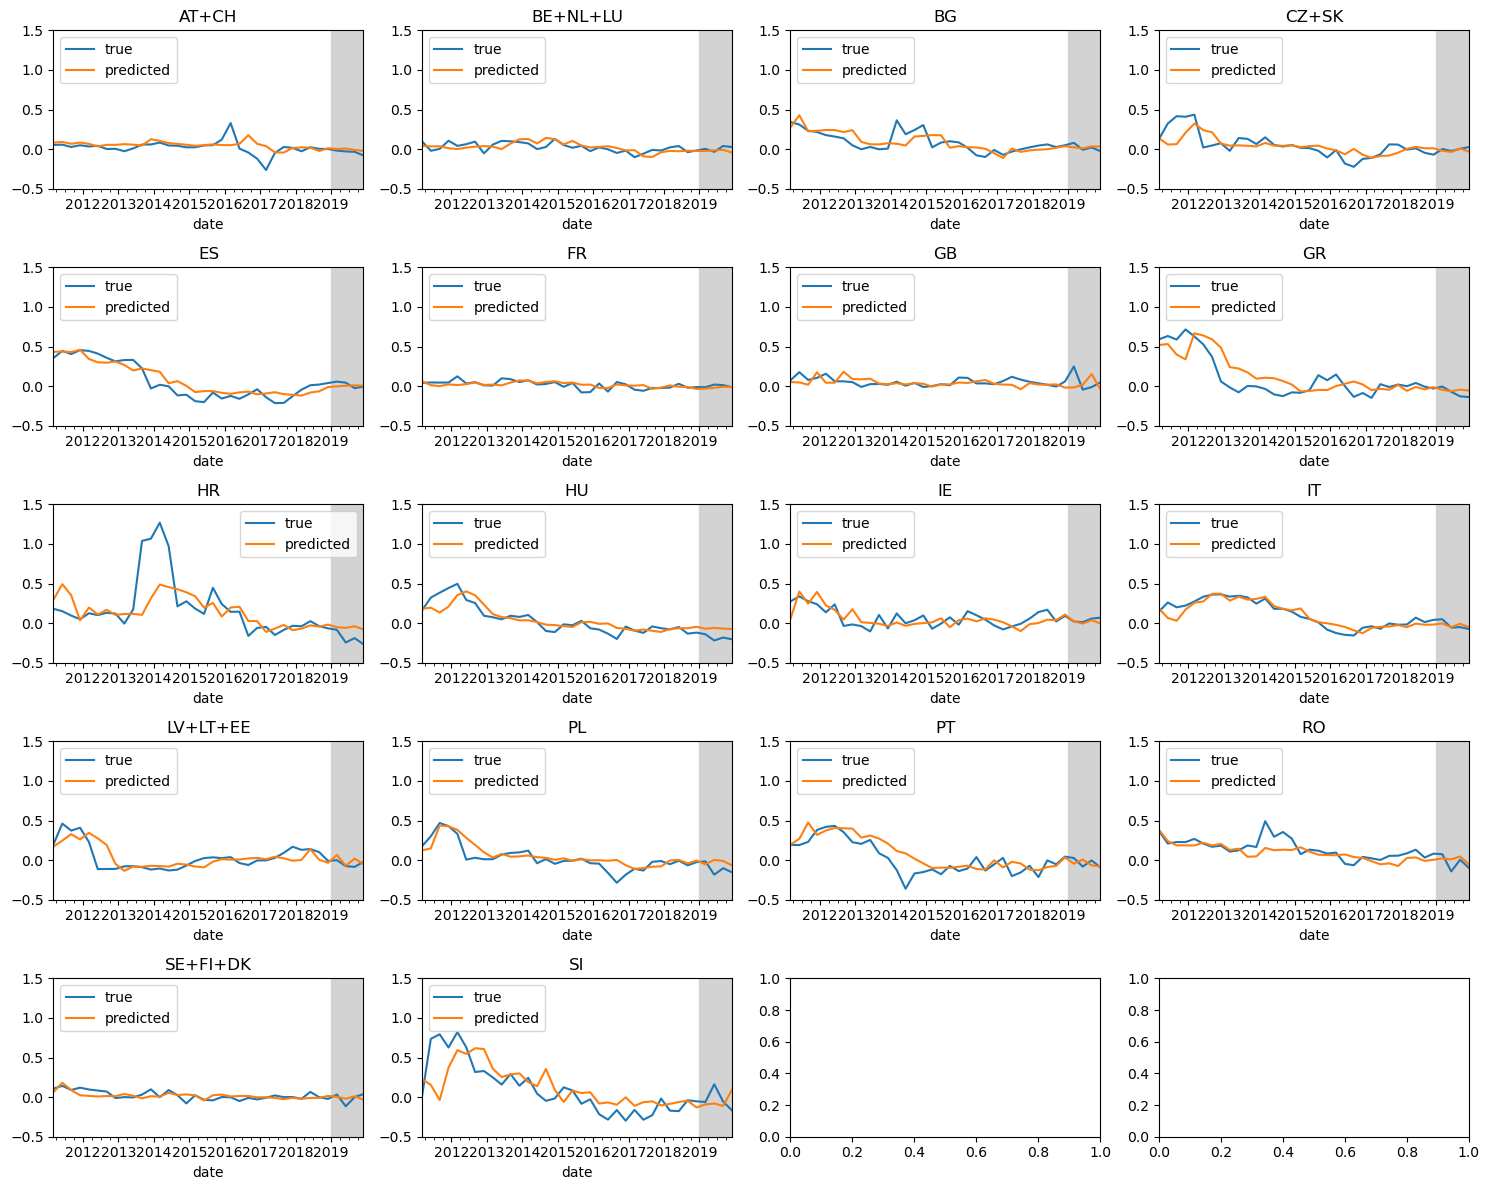

In [51]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()


Without own lags

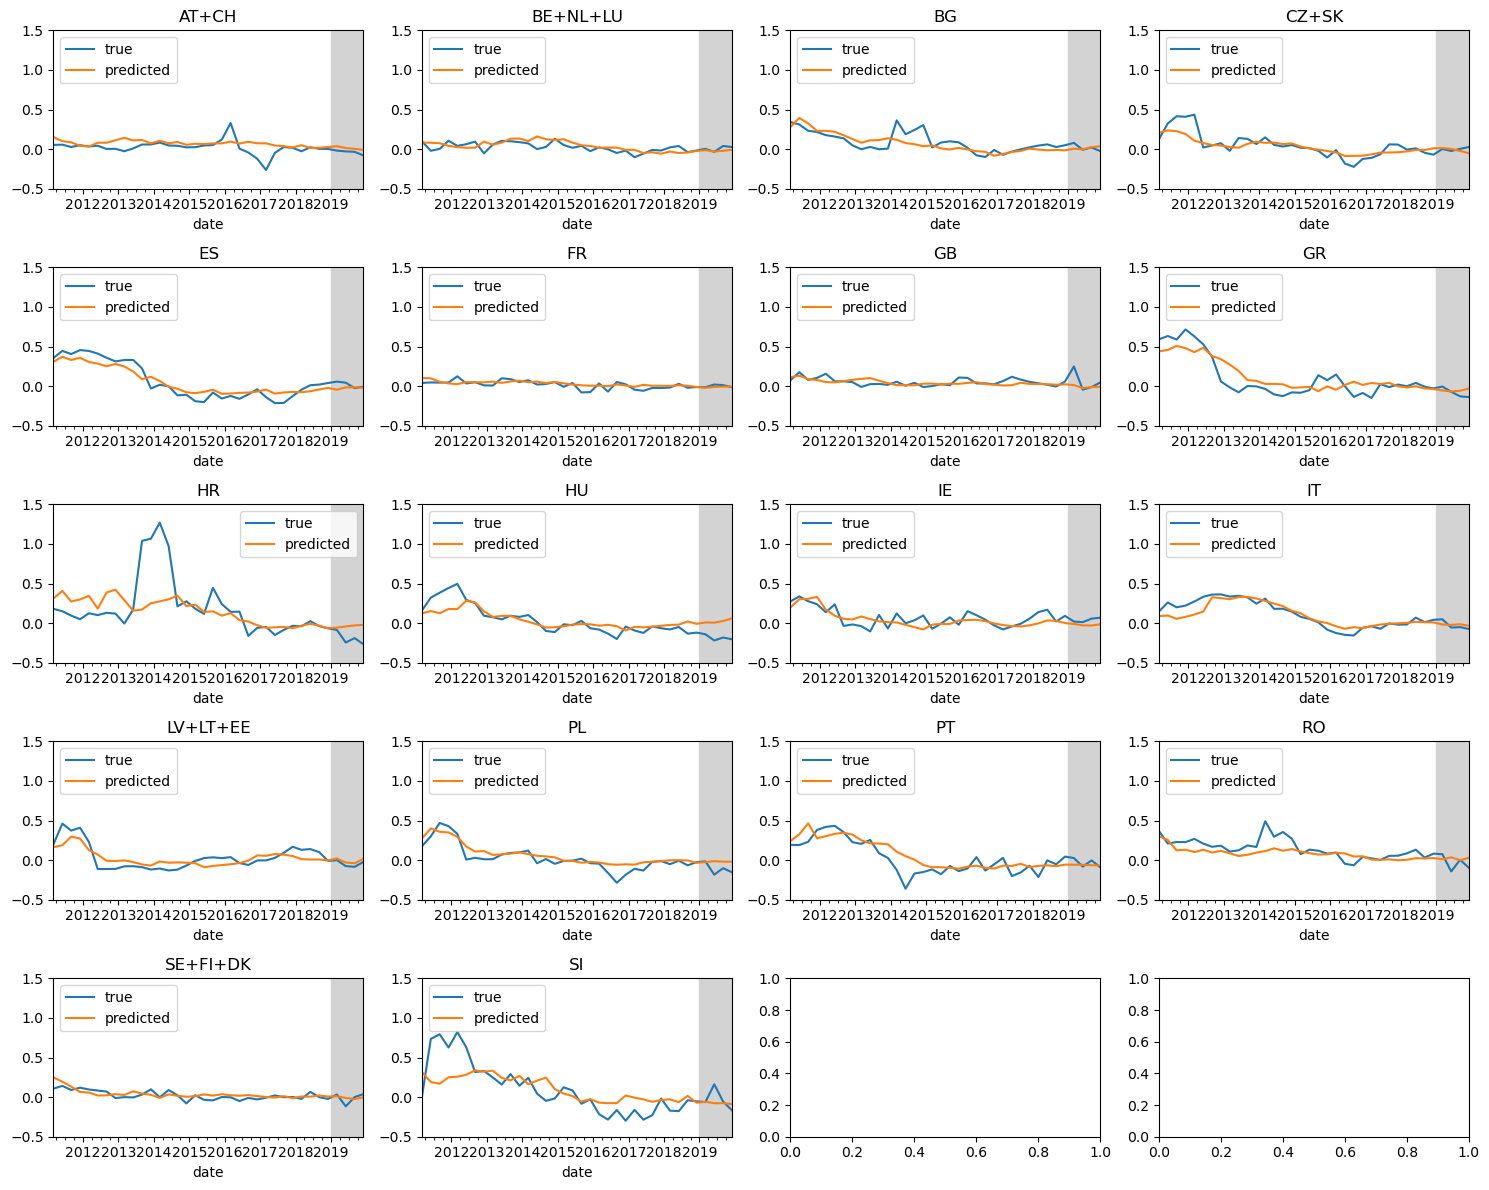

In [52]:
i = model_names.index("19+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_random)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()

Without Google Trends

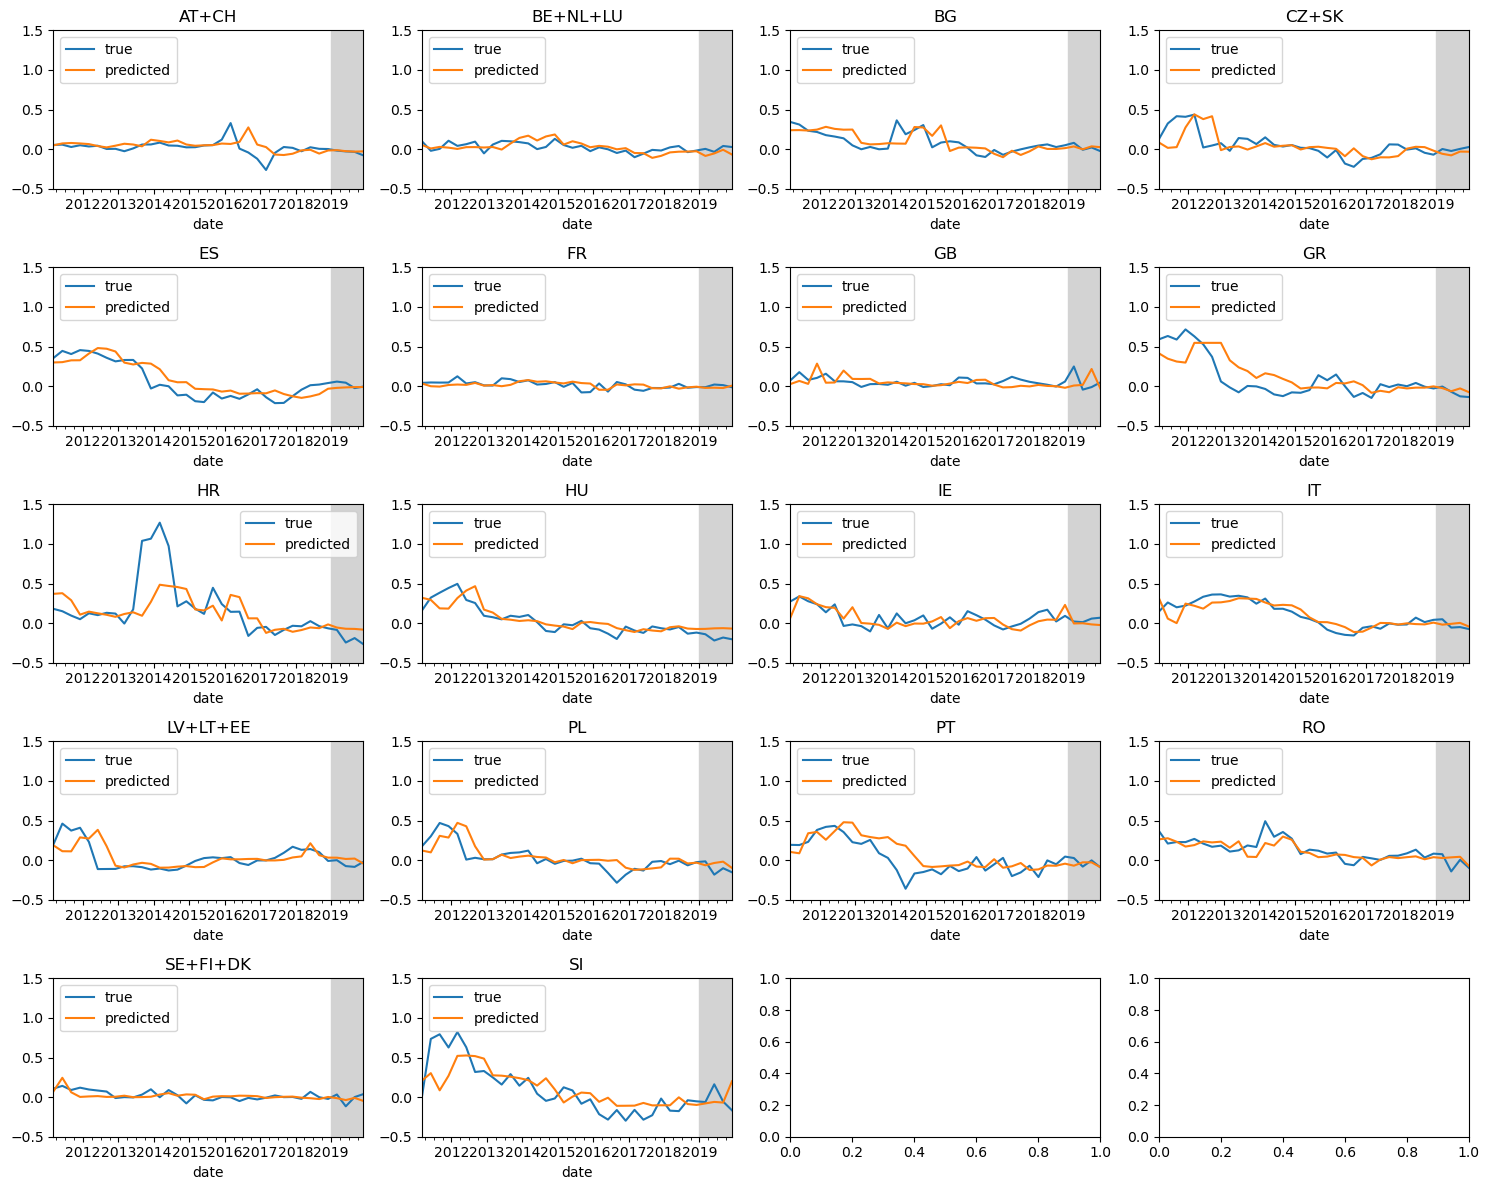

In [53]:
i = model_names.index("ar+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()

Comparison

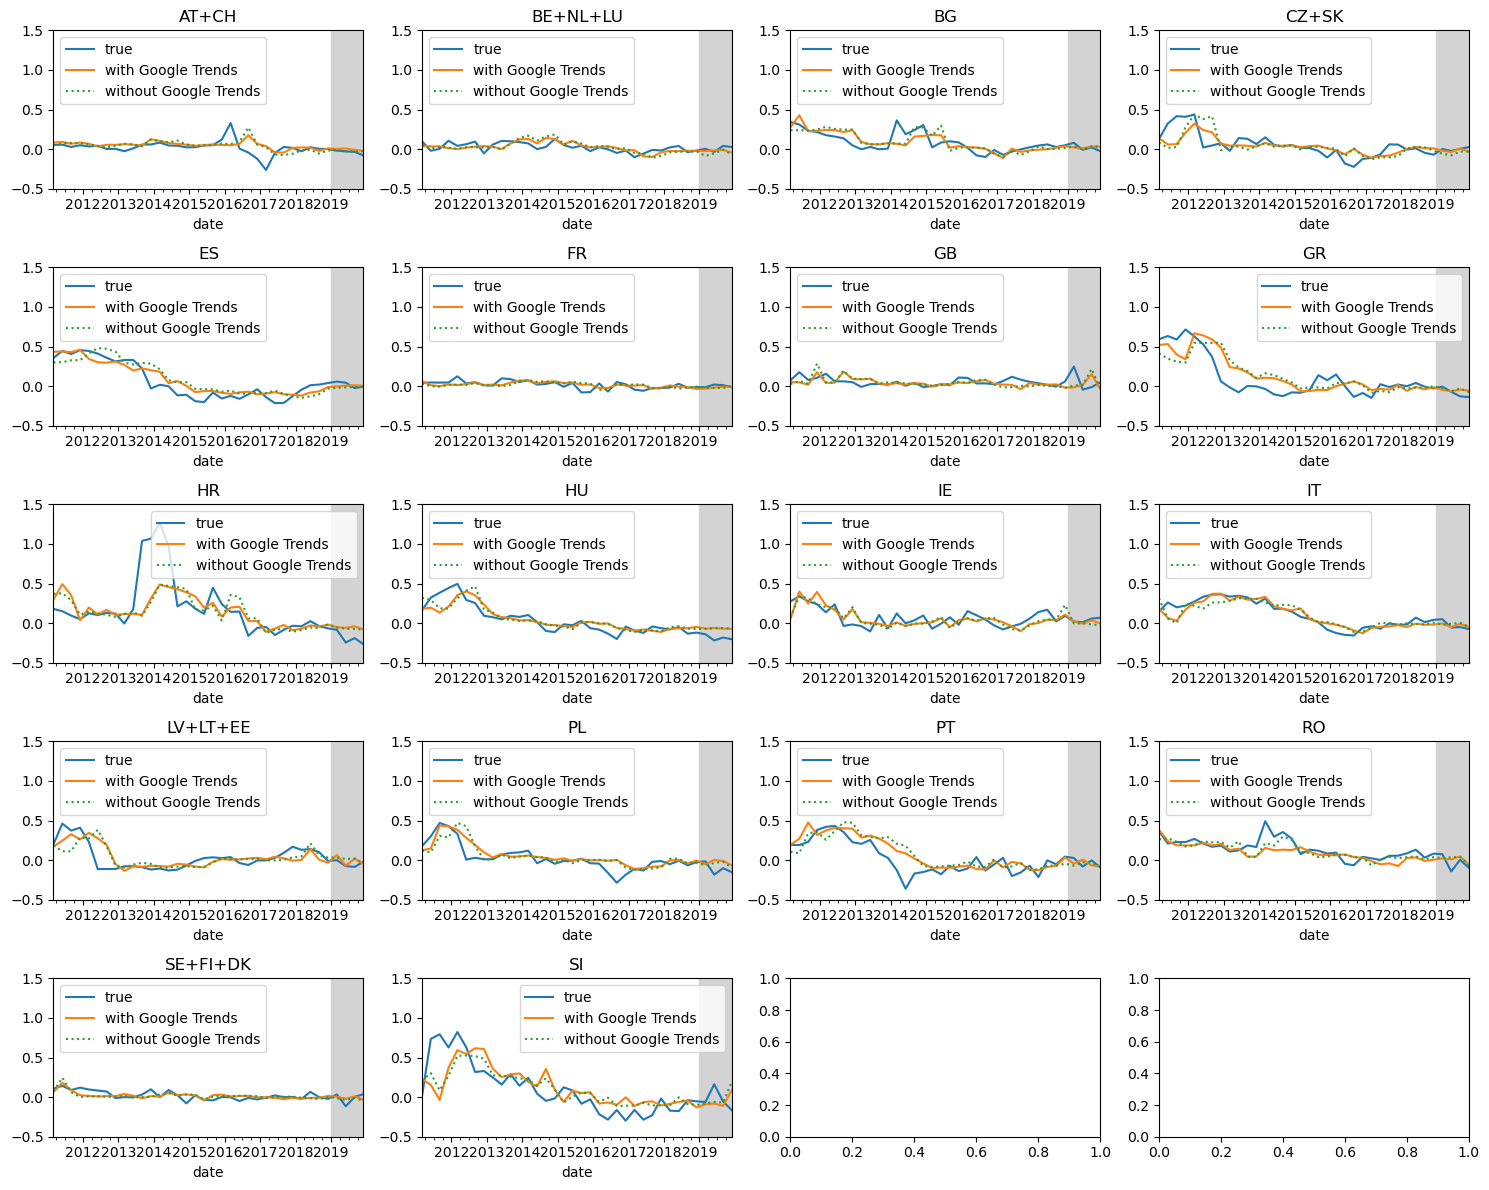

In [54]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"with Google Trends": y_pred_i1, "without Google Trends": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
    style={"without Google Trends": ":"}
)
plt.show()